In [0]:
from google.colab import drive
drive.mount('/content/drive/')

!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
drive  sample_data


In [0]:
import csv
import numpy as np
import random
import torch
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt 
import torchvision
from torchvision import datasets, transforms, utils


from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu90' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
link = 'drive/My Drive/APS360/'

class ImageFolder(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolder, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_index = (original_tuple + (index,))
        return tuple_with_index

class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)
    

def get_data_loader(batch_size, position="samePos"):
    
    transform = transforms.Compose([transforms.ToTensor()])
    
    ori_data = torchvision.datasets.ImageFolder(link+'resized_images/wide', transform = transform)
    
    if position == "diffPos":
        data = torchvision.datasets.ImageFolder(link+'watermarked_image/diffPos/1', \
                                                transform = transform)
    else:
        data = torchvision.datasets.ImageFolder(link+'watermarked_image/samePos/2', \
                                                transform = transform)
        
        
    labeled_data = ConcatDataset(ori_data, data)
    
    trainLen = int(0.6*len(labeled_data))
    valLen = int(0.2*len(labeled_data))
    testLen = int(0.2*len(labeled_data))

    train_data, val_data, test_data = torch.utils.data.dataset.random_split \
    (labeled_data, [trainLen, valLen, testLen])
    
    train_loader = torch.utils.data.DataLoader(train_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    val_loader = torch.utils.data.DataLoader(val_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    test_loader = torch.utils.data.DataLoader(test_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    
    return train_loader, val_loader, test_loader

# NOTE: THIS ONLY USES ONE FOLDER!
train_loader, val_loader, test_loader = get_data_loader(1)
print(len(train_loader), len(val_loader), len(test_loader))

825 275 275


In [0]:
# from torchvision import datasets, transforms, utils

# transform = transforms.Compose(
#             [transforms.ToTensor(),
#              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# class ImageFolder(datasets.ImageFolder):
#     """Custom dataset that includes image file paths. Extends
#     torchvision.datasets.ImageFolder
#     """

#     # override the __getitem__ method. this is the method dataloader calls
#     def __getitem__(self, index):
#         # this is what ImageFolder normally returns 
#         original_tuple = super(ImageFolder, self).__getitem__(index)
#         # the image file path
#         path = self.imgs[index][0]
#         # make a new tuple that includes original and the path
#         tuple_with_index = (original_tuple + (index,))
#         return tuple_with_index

# class ConcatDataset(torch.utils.data.Dataset):
#     def __init__(self, *datasets):
#         self.datasets = datasets

#     def __getitem__(self, i):
#         return tuple(d[i] for d in self.datasets)

#     def __len__(self):
#         return min(len(d) for d in self.datasets)
    
# traindir_A = 'resized_images_copy'
# traindir_B = 'watermarked_image_copy'
# train_loader = torch.utils.data.DataLoader(
#              ConcatDataset(
#                  datasets.ImageFolder(traindir_A, transform=transform),
#                  datasets.ImageFolder(traindir_B, transform=transform)
#              ),shuffle=False,batch_size = 64)

# data_dir = 'resized_images_copy'
# data_set_original = ImageFolder(data_dir, transform=transform)
# data_loader_original = torch.utils.data.DataLoader(data_set_original, shuffle=False)

# data_dir = 'watermarked_image_copy'
# data_set_watermark = ImageFolder(data_dir, transform=transform)
# data_loader_watermark = torch.utils.data.DataLoader(data_set_watermark, shuffle=False)


# print(len(data_loader_original))
# print(len(data_loader_watermark))
# print(len(train_loader))

In [0]:
class AutoencoderConv(nn.Module):
    def __init__(self):
        super(AutoencoderConv, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

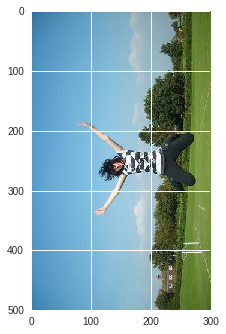

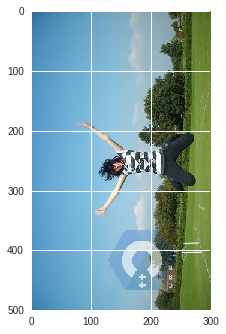

In [0]:
original,watermarked = next(iter(train_loader))
img_orig = original[0].detach().numpy()
plt.imshow(img_orig[0].T)
plt.show()

img_watermarked = watermarked[0].detach().numpy()
plt.imshow(img_watermarked[0].T)
plt.show()

In [0]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-4):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    outputs = []
    for epoch in range(num_epochs):
        for original, watermarked in train_loader:
            original_img, _ = original
            watermarked_img, _ = watermarked
            original_img = original_img.cuda()
            watermarked_img = watermarked_img.cuda()
            
            recon = model(watermarked_img)
            
            loss = criterion(recon, original_img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            outputs.append((epoch, original_img, recon),)
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        
    return outputs

In [0]:
model = AutoencoderConv()
model.cuda()

AutoencoderConv(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [0]:
epochs = 100
outputs = train(model, num_epochs=epochs)

Epoch:1, Loss:0.0445
Epoch:2, Loss:0.0325
Epoch:3, Loss:0.0292
Epoch:4, Loss:0.0266
Epoch:5, Loss:0.0248
Epoch:6, Loss:0.0234
Epoch:7, Loss:0.0223
Epoch:8, Loss:0.0213
Epoch:9, Loss:0.0204
Epoch:10, Loss:0.0196
Epoch:11, Loss:0.0189
Epoch:12, Loss:0.0183
Epoch:13, Loss:0.0178
Epoch:14, Loss:0.0173
Epoch:15, Loss:0.0168
Epoch:16, Loss:0.0164
Epoch:17, Loss:0.0160
Epoch:18, Loss:0.0157
Epoch:19, Loss:0.0153
Epoch:20, Loss:0.0150
Epoch:21, Loss:0.0148
Epoch:22, Loss:0.0145
Epoch:23, Loss:0.0143
Epoch:24, Loss:0.0140
Epoch:25, Loss:0.0138
Epoch:26, Loss:0.0136
Epoch:27, Loss:0.0134
Epoch:28, Loss:0.0132
Epoch:29, Loss:0.0130
Epoch:30, Loss:0.0128
Epoch:31, Loss:0.0127
Epoch:32, Loss:0.0125
Epoch:33, Loss:0.0123
Epoch:34, Loss:0.0122
Epoch:35, Loss:0.0120
Epoch:36, Loss:0.0119
Epoch:37, Loss:0.0117
Epoch:38, Loss:0.0116
Epoch:39, Loss:0.0115
Epoch:40, Loss:0.0114
Epoch:41, Loss:0.0112
Epoch:42, Loss:0.0111
Epoch:43, Loss:0.0109
Epoch:44, Loss:0.0108
Epoch:45, Loss:0.0107
Epoch:46, Loss:0.01

In [0]:
# for k in range(0, 30, 10):
#     plt.figure(figsize=(15, 5))
#     imgs = outputs[k][1]
#     recon = outputs[k][2]
    
#     # print original watermarked image
#     for i, item in enumerate(imgs):
#         if i >= 5: break
          
# #         if k == 0:
# #           img_orig = torch.squeeze(item[0])
# #           print(type(img_orig))
# #           img_orig = np.transpose(img_orig.cpu(), [1,2,0])
# #           plt.imshow(img_orig)
# #           plt.show()

#         plt.subplot(2, 5, i+1)
#         plt.imshow(item[0])
        
#     for i, item in enumerate(recon):
#         if i >= 5: break
#         plt.subplot(2, 5, 5+i+1)
#         plt.imshow(item[0])



for k in range(0, 100,10):
    plt.figure(figsize=(25, 15))
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    if k ==0:
      for i, item in enumerate(imgs):
          if i >= 5: break
          plt.subplot(2, 1, i+1)
          plt.imshow(item[0])
  #         plt.imsave(str(i)+"original.png",item[0])
        
    for i, item in enumerate(recon):
        if i >= 5: break
        plt.subplot(2, 1, i+1+1)
        plt.imshow(item[0])
#         plt.imsave(str(i)+"recon.png",item[0])


# for k in range(0, 30, 10):
#     plt.figure(figsize=(15, 5))
#     imgs = outputs[k][1]
# #     recon = outputs[k][2]
#     recon = outputs[k][2].cpu().detach().numpy()
    
#     # print original watermarked image  
#     if k == 0:
#       for i, item in enumerate(imgs):
#           if i >= 5: break
            
#           img_orig = torch.squeeze(item)
#           img_orig = np.transpose(img_orig.cpu(), [1,2,0])

#           plt.subplot(2, 5, i+1)
#           plt.imshow(img_orig)
        
#     for i, item in enumerate(recon):
#         if i >= 5: break
          
# #         img_recon = torch.squeeze(jitem)
# #         img_recon = np.transpose(img_recon.cpu(), [1,2,0])
#         img_recon = item
#         plt.subplot(2, 5, 5+i+1)
#         plt.imshow(item[0])

torch.Size([300, 500, 3])


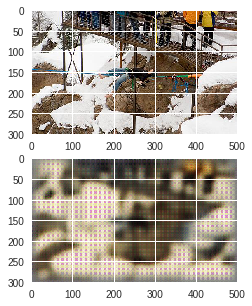

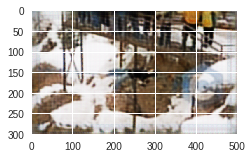

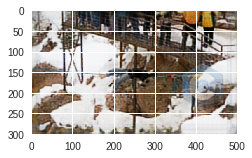

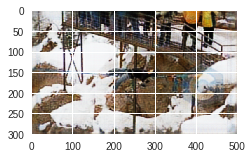

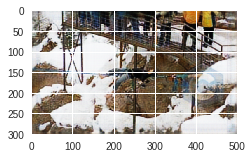

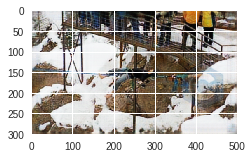

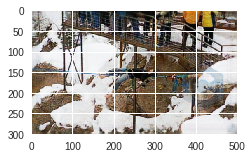

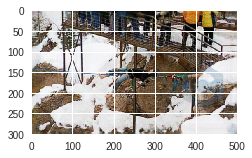

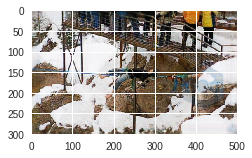

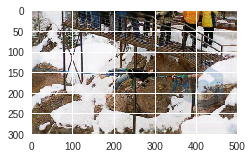

In [0]:
for k in range(0, 100, 10):
    plt.figure(figsize=(15, 5))
    imgs = outputs[k][1]
#     recon = outputs[k][2]
    recon = outputs[k][2]
    
    # print original watermarked image  
    if k == 0:
      for i, item in enumerate(imgs):
          if i >= 3: break
            
          img_orig = torch.squeeze(item)
          img_orig = np.transpose(img_orig.cpu(), [1,2,0])

          plt.subplot(2, 3, i+1)
          print(img_orig.shape)
          plt.imshow(img_orig)
        
    for i, item in enumerate(recon):
        if i >= 3: break
        
        img_recon = torch.squeeze(item)
        img_recon = np.transpose(img_recon.cpu().detach(), [1,2,0])
      
        plt.subplot(2, 3, 3+i+1)
        plt.imshow(img_recon)


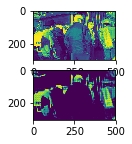

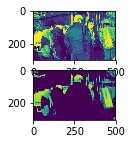

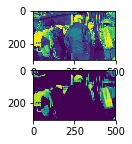

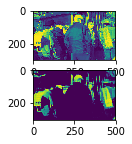

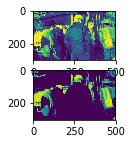

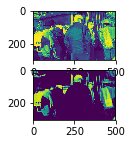

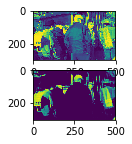

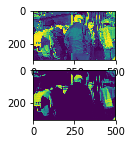

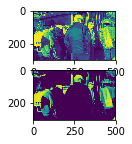

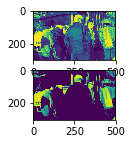

In [0]:
for k in range(0, 100, 10):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 1, i+1)
        plt.imshow(item[0])
        plt.imsave(str(k)+"original.png",item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 1, 1+i+1)
        plt.imshow(item[0])
        plt.imsave(str(k)+"recon.png",item[0])

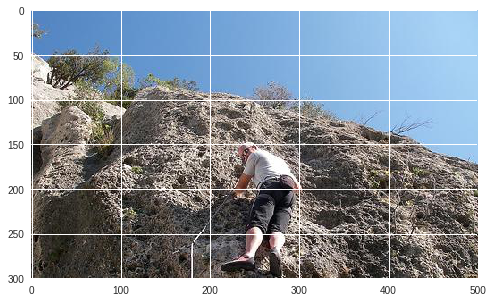

In [0]:
img = plt.imread(link+'resized_images/wide/test/2.jpg') 
plt.imshow(img)
plt.show()

In [0]:
img = img.T
img = np.expand_dims(img, axis=0)
torch.tensor(img).shape

torch.Size([1, 3, 500, 300])

In [0]:
y = model(torch.tensor(img).type('torch.cuda.FloatTensor'))

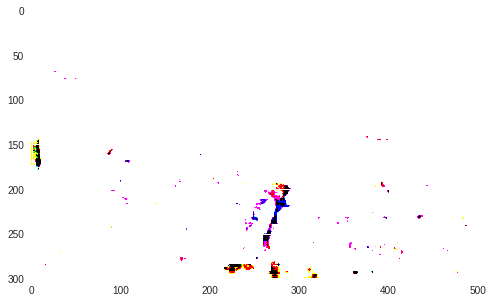

In [0]:
img_out = y.cpu().detach().numpy()
plt.imshow(img_out[0].T)
plt.show()

In [0]:
out = model2(watermarked[0])

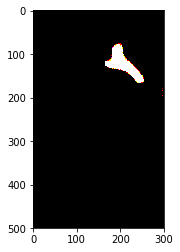

In [0]:
img_out = out.detach().numpy()
plt.imshow(img_out[0].T)
plt.show()